In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
def add_label_noise(labels, p=0.1):
    num_labels = int(len(labels))
    num_change = int(p * len(labels))
    
    idx = torch.randperm(num_labels)[:num_change]

    new_labels = torch.randint(0, 10, (num_change,))
    labels[idx] = new_labels
    return labels
print(add_label_noise(torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 0]), 0.8))

trainset.targets = add_label_noise(torch.tensor(trainset.targets), p=0.2).tolist()

tensor([4, 5, 0, 3, 5, 6, 7, 4, 2, 0])


In [5]:
batch_size = 128

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
                                
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

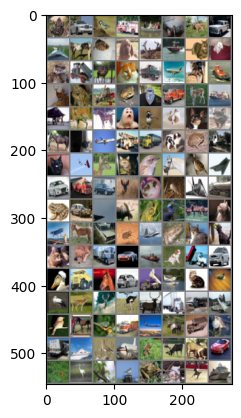

frog  car   bird  truck ship  car   car   car   plane horse cat   dog   plane deer  cat   dog   cat   truck deer  cat   truck plane bird  ship  frog  frog  plane frog  ship  truck deer  ship  frog  deer  bird  dog   bird  dog   ship  bird  horse cat   plane truck truck dog   frog  truck cat   plane deer  cat   bird  horse bird  plane car   truck car   deer  dog   horse plane plane frog  frog  plane deer  frog  ship  car   cat   plane horse car   horse plane plane cat   truck cat   frog  truck car   ship  dog   truck car   bird  truck horse car   truck plane cat   cat   horse deer  deer  bird  deer  truck truck truck bird  horse frog  truck plane deer  truck frog  deer  ship  bird  plane frog  deer  deer  car   deer  bird  bird  bird  frog  horse horse ship 


In [6]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [7]:
from resnet import ResNet

In [8]:
net = ResNet()
net = net.to(device)

In [9]:
# print number of parameters
print(sum(p.numel() for p in net.parameters()))

11174026


In [10]:
optim = torch.optim.SGD(net.parameters(), lr=3e-4, momentum=0.9)

In [11]:
lossi = []
testi = []

In [12]:
def estimate_loss(split="train"):
    if split == "train":
        loader = trainloader
    else:
        loader = testloader
    loss = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss += F.cross_entropy(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
    return loss / len(loader)

In [22]:
epochs = 128

for epoch in range(epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optim.zero_grad()
        outputs = net(inputs)
        loss = F.cross_entropy(outputs, labels)
        lossi.append(loss.item())
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'[{epoch}, {i}] loss: {loss.item()}')

    test_loss = estimate_loss("test")
    print(f'[{epoch}] test loss: {test_loss}')
    testi.append(test_loss)


[0, 0] loss: 0.0011719005415216088
[0, 200] loss: 0.0004678307450376451
[0] test loss: 1.557807527010954
[1, 0] loss: 0.00044469459680840373
[1, 200] loss: 0.00023196934489533305
[1] test loss: 1.5683280863339388
[2, 0] loss: 0.0005319043411873281
[2, 200] loss: 0.0007946435362100601
[2] test loss: 1.5606221383131003
[3, 0] loss: 0.0006395583041012287
[3, 200] loss: 0.0002808029530569911
[3] test loss: 1.5633407076702843
[4, 0] loss: 0.0005142370355315506
[4, 200] loss: 0.00025203704717569053
[4] test loss: 1.564246740522264
[5, 0] loss: 0.0005736608291044831
[5, 200] loss: 0.0011020113015547395
[5] test loss: 1.5668595878383782
[6, 0] loss: 0.0005677239969372749
[6, 200] loss: 0.0004371307441033423
[6] test loss: 1.562768518170224
[7, 0] loss: 0.00022647388686891645
[7, 200] loss: 0.0003763840941246599
[7] test loss: 1.5638010743298107
[8, 0] loss: 0.00031224425765685737
[8, 200] loss: 0.0003686100826598704
[8] test loss: 1.5625708374796035
[9, 0] loss: 0.00022245215950533748
[9, 200]

In [14]:
def check_accuracy(split="test"):
    if split == "train":
        loader = trainloader
    else:
        loader = testloader
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    net.train()
    print(f'{split} accuracy: {correct / total}')
    return correct / total

check_accuracy("test")
check_accuracy("train")

test accuracy: 0.6624
train accuracy: 1.0


1.0

In [15]:
import matplotlib.pyplot as plt

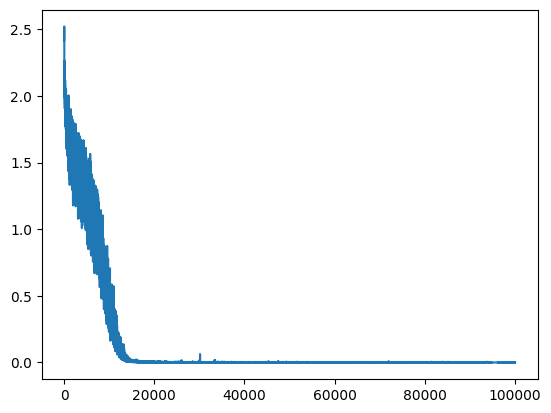

In [23]:
plt.plot(lossi)

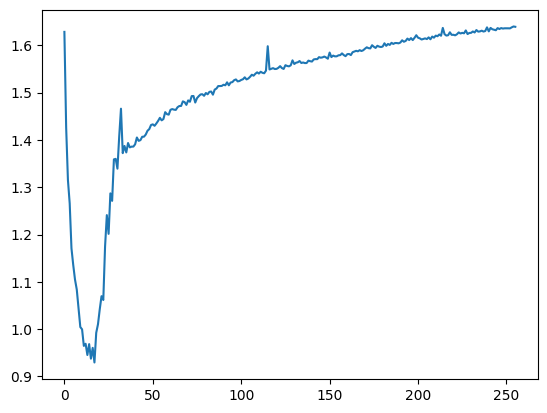

In [24]:
plt.plot(testi)